In [1]:
# Hyperparameters
test_results = True
T = 15 # Simulation time
N = 10 # MPC horizon
n_from_index = 0 # How distant the first point is
frame_rate = 10

In [2]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_trajectory, get_position, my_odometry


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.39 path /home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages pyparsing 3.0.9
DEBUG:gym-duckietown:gym-duckietown version 6.1.31 path /home/buswayne/Documents/GitHub/gym-duckietown/src



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}


In [3]:
plt.rcParams['figure.figsize'] = [7, 7]

In [4]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [5]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate
)

INFO:duckietown_world: data: /home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages/duckietown_world/data
/home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


In [6]:
#env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]
env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

In [7]:
dt = 1.0 / env.frame_rate

In [8]:
env.reset()
traj = get_trajectory(env, samples=200, method="distance", last_value_distance=1.002)
x_min = traj[:,0].min()
y_min = traj[:,1].min()

/home/buswayne/Documents/GitHub/duckrace/utils.py:390: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [9]:
pose = get_position(env)
pose

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

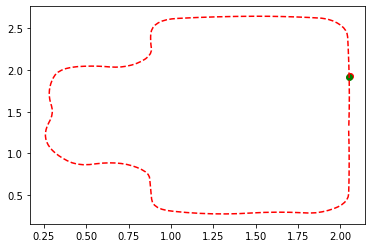

In [10]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

In [11]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 124.0'

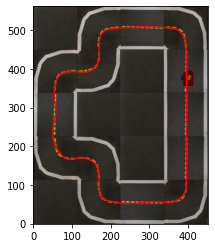

In [12]:
utils.show_on_map_array(env, traj[:,:2])

In [13]:
get_position(env)

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

In [14]:
# # Compute the angle between every consecutive points in traj
# angles = np.zeros(traj.shape[0])
# for i in range(traj.shape[0]-1):
#     angles[i] = np.arctan2(traj[i+1,1]-traj[i,1], traj[i+1,0]-traj[i,0])
# angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [15]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
angles[angles < 0] += 2 * np.pi

In [16]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [17]:
# traj = np.repeat(traj, 6, axis=0)
# traj.shape

In [18]:
# Drop values to fix weird final angle
# traj = traj[1:-1]

Plot angles:

If faces right red, else blue

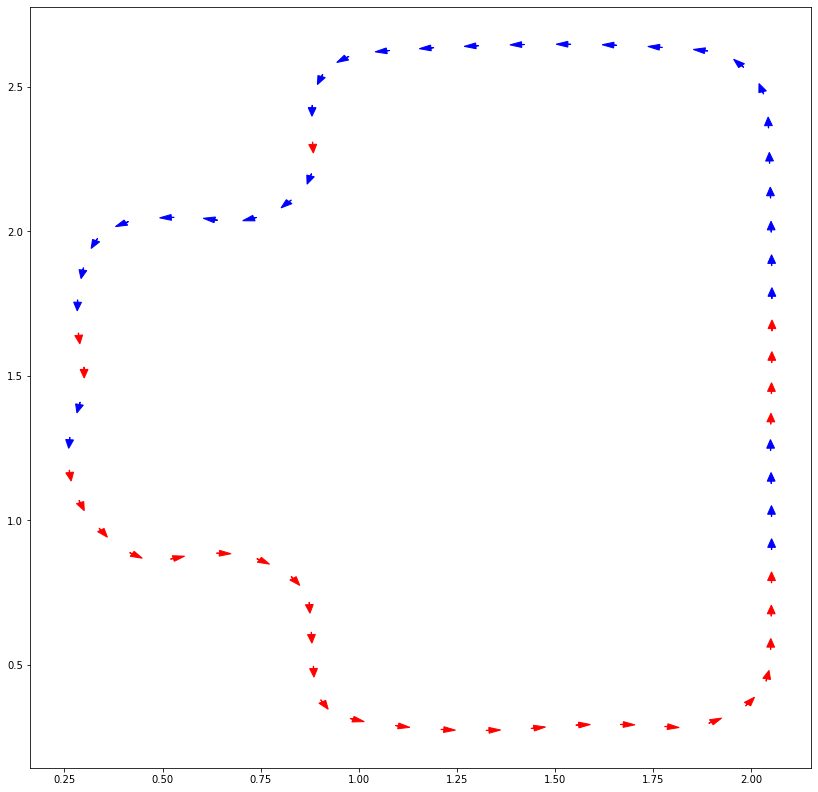

In [19]:
c="r"
fig = plt.figure(figsize=(14,14))
for x, y, t in traj[::3]:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = "b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.008*np.sin(t), color=c, head_width=0.02)

In [20]:
traj[index]

array([2.05126018, 1.91873737, 1.58115685])

In [21]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [22]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [23]:
pose = get_position(env)

DAE

In [24]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[2.055, 1.92971, 1.5708, 0.3, 0]


/home/buswayne/Documents/GitHub/duck_env/lib/python3.8/site-packages/geometry/poses.py:274: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  linear = np.array(linear, dtype='float64')


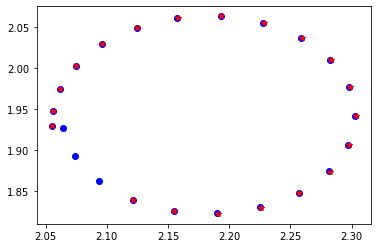

In [25]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = np.array(sim(x0, [1, 0.2]))
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [38]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
u_prev_0 = [.0, .0]
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T

In [39]:
#def mod(n, base):
#    return n - floor(n/base) * base

In [40]:
weights_0 = [1e3, 1e2, 1e-2, 1]
theta_0 = [0, 0, 0]
gamma = 0.9

In [41]:
def position_cost(x,r):
    delta = 10
    return delta**2 * (np.sqrt(1 + (((x[0]-r[0])**2 + (x[1]-r[1])**2)/delta**2))-1)
def heading_cost(psi,tr):
    return (1 - np.cos(psi - tr))/2

In [290]:
#scaling_weights = [1e3, 1e3, 1, 1e-1]
#scaling_theta = [1, 1e3, 1e3]
scaling_weights = [1, 1, 1, 1]
scaling_theta = [1, 1, 1]

opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay
u_prev = opti.parameter(2,1)

weights = opti.parameter(4)
theta = opti.parameter(3)

Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
R = weights[3]

theta_lambda = theta[0]
theta_f_1 = theta[1]
theta_f_2 = theta[2]
# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
#obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)#R*sumsqr(u[:,1:]-u[:,:-1])
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

        # Setup the problem 

# Constraints Definition
cost = scaling_theta[0] * theta_lambda + \
       scaling_weights[0] * Q1 * position_cost(x[:2, 0], r[:,0]) +\
       scaling_weights[1] * Q2 * heading_cost(x[2, 0],tr[:,0]) +\
       scaling_weights[2] * Q3 * sumsqr(x[3, 0]-0.6) +\
       scaling_weights[3] * R * sumsqr(u[:,0]-u_prev)

opti.subject_to(x[:,1]==F(x[:,0],u[:,0]))

# 1) System dynamics constraint over the prediction horizon
for k in range(1,N):
    cost += gamma**k * (scaling_weights[0] * Q1 * position_cost(x[:2, k], r[:,k]) +\
                        scaling_weights[1] * Q2 * heading_cost(x[2, k],tr[:,k]) +\
                        scaling_weights[2] * Q3 * sumsqr(x[3, k]-0.6) +\
                        scaling_weights[3] * R * sumsqr(u[:,k]-u[:,k-1]))
    # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
    
cost += gamma**N * (scaling_theta[1] * theta_f_1 * sumsqr(x[:2, N]-r[:,N]) +\
                    scaling_theta[2] * theta_f_2 * heading_cost(x[2, N],tr[:,N]))#sumsqr(mod(x[2, N], 2*np.pi) - tr[:,N]))
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
#opti.subject_to(x[3,:] >= 0)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay
opti.set_value(u_prev, u_prev_0) # Initial delay

opti.set_value(weights, weights_0)
opti.set_value(theta, theta_0)
                    
opti.minimize(cost)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()
    
V = opti.to_function('V',[p, r, tr, u_delay, u_prev, weights, theta], # inputs
                         [cost, u[:,0], gradient(cost + opti.lam_g.T @ opti.g, weights), gradient(cost + opti.lam_g.T @ opti.g, theta)], # outputs
                         ['p', 'r', 'tr', 'u_delay', 'u_prev', 'weights', 'theta'],
                         ['cost', 'u_opt', 'gradient_weights', 'gradient_theta'])

In [291]:
u_s = [.0, .0]
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay
u_prev = opti.parameter(2,1)
u_0 = opti.parameter(2,1)

weights = opti.parameter(4)
theta = opti.parameter(3)
#beta = opti.parameter(1)

#beta1 = beta[0]
#beta2 = beta[1]

Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
R = weights[3]

theta_lambda = theta[0]
theta_f_1 = theta[1]
theta_f_2 = theta[2]

# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
#obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)#R*sumsqr(u[:,1:]-u[:,:-1])
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

        # Setup the problem 

# Constraints Definition
cost = scaling_theta[0] * theta_lambda + \
       scaling_weights[0] * Q1 * position_cost(x[:2, 0], r[:,0]) +\
       scaling_weights[1] * Q2 * heading_cost(x[2, 0],tr[:,0]) +\
       scaling_weights[2] * Q3 * sumsqr(x[3, 0]-0.6) +\
       scaling_weights[3] * R * sumsqr(u[:,0]-u_prev)

opti.subject_to(x[:,1]==F(x[:,0],u[:,0]))

# 1) System dynamics constraint over the prediction horizon
for k in range(1,N):
    cost += gamma**k * (scaling_weights[0] * Q1 * position_cost(x[:2, k], r[:,k]) +\
                        scaling_weights[1] * Q2 * heading_cost(x[2, k],tr[:,k]) +\
                        scaling_weights[2] * Q3 * sumsqr(x[3, k]-0.6) +\
                        scaling_weights[3] * R * sumsqr(u[:,k]-u[:,k-1]))
    # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
    
cost += gamma**N * (scaling_theta[1] * theta_f_1 * sumsqr(x[:2, N]-r[:,N]) +\
                    scaling_theta[2] * theta_f_2 * heading_cost(x[2, N],tr[:,N]))#sumsqr(mod(x[2, N], 2*np.pi) - tr[:,N]))

# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
#opti.subject_to(x[3,:] >= 0)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)
opti.subject_to(u[:,0] == u_0)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay
opti.set_value(u_prev, u_prev_0)
opti.set_value(u_0, u_s)

opti.set_value(weights, weights_0)
opti.set_value(theta, theta_0)

opti.minimize(cost)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()
    
Q = opti.to_function('Q',[p, r, tr, u_delay, u_prev, u_0, weights, theta], # inputs
                         [cost, gradient(cost + opti.lam_g.T @ opti.g, weights), gradient(cost + opti.lam_g.T @ opti.g, theta)], # outputs
                         ['p', 'r', 'tr', 'u_delay', 'u_prev', 'u_0', 'weights', 'theta'],
                         ['cost', 'gradient_weigths', 'gradient_theta'])

In [303]:
def stage_cost(x, r, tr):
    #scaling_factor = [1/5e-2, 1/1.745e-1, 1/0.52]
    scaling_factor = [1, 1, 1]
    # how to determine? Establish acceptable level
    # tracking with 0.05 is OK. To have magnitude 1 --> 1/0.05
    # tracking angle with 10 deg (0.1745 rad) is ok --> 1/0.1745
    # max speed: greater then 0.52 --> 1/0.52
    weights = [1e4, 1, 1]
    #print('Cost due to x: ', scaling_factor[0] * (x[0]-r[0,0])**2)
    #print('Cost due to y: ', scaling_factor[0] * (x[1]-r[1,0])**2)
    #print('Cost due to theta: ', scaling_factor[1] * (mod(x[2],2*np.pi)-tr[0])**2)
    #print('Cost due to speed: ', scaling_factor[2] * (x[3]-0.6)**2)
    return weights[0] * scaling_factor[0] * (x[0]-r[0,0])**2 + \
           weights[0] * scaling_factor[0] * (x[1]-r[1,0])**2 + \
           weights[1] * scaling_factor[1] * (mod(x[2],2*np.pi)-tr[0])**2 + \
           weights[2] * scaling_factor[2] * (x[3]-0.6)**2
    #return weights[0] * scaling_weights[0] * (x[0]-r[0,0])**2 + \
    #       weights[0] * scaling_weights[0] * (x[1]-r[1,0])**2 + \
    #       weights[1] * scaling_weights[1] * heading_cost(x[2],tr[0]) + weights[2] * scaling_weights[2] * (x[3]-0.6)**2

def stage_cost_model(x, r, tr, weights_0, a):
    Q1 = weights_0[0]
    Q2 = weights_0[1]
    Q3 = weights_0[2]
    R = weights_0[3]
    print('Cost due to position: ', Q1*position_cost(x[:2], r[:,0]))
    print('Cost due to theta: ', Q2*heading_cost(x[2],tr[0]))
    print('Cost due to speed: ', Q3*sumsqr(x[3]-0.6))
    print('Cost due to control action: ', R*sumsqr(a))
    #return Q1*position_cost(x[:2], r[:,0]) + Q2*heading_cost(x[2],tr[0]) + Q3*sumsqr(x[3]-0.6) + R*sumsqr(a)
    #return Q*sumsqr(x[:2]-r) + Q2*sumsqr(mod(x[2]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3]-0.6) + R*sumsqr(a)

# MPC loop
gamma = 0.9
alpha_1 = 1e-4
alpha_2 = 1e-4
weights_0 = [100, 5e-4, 10, 1e-3]
#weights_0 = [1e3, 1e2, 1e-2, 1]
#weights_0 = [0, 0, 0, 0]
#weights_0 = [1, 1, 1, 1]
theta_0 = [0, 0, 0]
#weights_0 = [100, 0.0148332, 10.054, 1.08164] # tuned, original 100, 5e-4, 10, 1e-3, max_speed = 0.3891 (non tuned 0.5260)
#weights_0 = [100, 0.0207271, 10.027, 0.710063] # tuned new stage cost, original 100, 5e-4, 10, 1e-3, max_speed = 0.3891 (non tuned 0.5260)
#theta_0 = [1.92382e-06, 2.81897e-09, 0.000776342] # tuned
#theta_0 = [1.17951e-06, 4.02384e-09, -2.73673e-05] # tuned stage cost new
#weights_0 = [106.582, 68.6181, 10.05, 0.106237] # test
#theta_0 = [0.111024, 1.45679, 1.56981] # test

autotune = True

X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
a_prev = [.0, .0]
r = r0
tr = t0
idx = index
u_delay = u_delay0
errors = []
error_x = []
error_y = []
error_theta = []
weights_vect = []
theta_vect = []
delta_vect = []
grad_weights_vect = []
grad_theta_vect = []

kdtree = spatial.KDTree(traj[:, :2])

for i in range(200):
    #print(i)
    V_cost, a, _, _ = V(x, r, tr, u_delay, a_prev, weights_0, theta_0)
    
    U_log = np.column_stack((U_log, a))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, a))[:, -delay:]

    # simulate
    x_next = F(x,a)
    
    Q_cost, Q_grad_weights, Q_grad_theta = Q(x, r, tr, u_delay, a_prev, a, weights_0, theta_0)
    #print(Q_grad)
    #
    #print(stage_cost(x, r, tr))
    #print(stage_cost_model(x, r, tr, weights_0, a))
    delta = stage_cost(x, r, tr) + gamma * V(x_next, r, tr, u_delay, a_prev, weights_0, theta_0)[0] - Q_cost
    #print(delta)
    #print(abs(delta))
    print(Q_grad_weights)
    #print(Q_grad_theta)
        
    if autotune:
        weights_0 = weights_0 + alpha_1 * delta * Q_grad_weights
        theta_0 = theta_0 + alpha_2 * delta * Q_grad_theta
        #print(alpha * delta * Q_grad)
        #beta_0 = beta_0 + alpha * delta * Q_grad
    
    x = x_next
    a_prev = a
    
    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    errors.append(np.sqrt(distance))
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2],2*np.pi)-traj[idx, 2])
    weights_vect.append(weights_0)
    theta_vect.append(theta_0)
    delta_vect.append(delta)
    grad_weights_vect.append(Q_grad_weights)
    grad_theta_vect.append(Q_grad_theta)

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    
    if idx+N+1 < traj.shape[0]:
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N+1-traj.shape[0], 2]).T
    #r = traj[idx:idx+N+1, :2].T
    #tr = traj[idx:idx+N+1, 2].T

[0.00277167, 0.00210728, 0.469059, 2.04053]
[0.00490951, 0.00636198, 0.149061, 0.264434]
[0.00579276, 0.0173534, 0.0797863, 0.355015]
[0.00688087, 0.033763, 0.0783785, 0.273074]
[0.00811869, 0.0646174, 0.0867244, 0.225134]
[0.00413905, 0.0721161, 0.0630957, 0.150943]
[0.00500255, 0.0578456, 0.0646694, 0.17926]
[0.00602514, 0.0495126, 0.0750808, 0.229528]
[0.00696416, 0.0385518, 0.0874993, 0.298483]
[0.00795597, 0.0289068, 0.0989965, 0.323165]
[0.00405364, 0.121303, 0.107656, 0.079411]
[0.00387885, 0.101446, 0.127888, 0.0441155]
[0.00382647, 0.0747976, 0.140492, 0.0451958]
[0.00395521, 0.0525498, 0.144297, 0.0416721]
[0.00437554, 0.0440934, 0.138532, 0.0374297]
[0.00518482, 0.0535931, 0.124743, 0.0330909]
[0.0065021, 0.0815006, 0.106198, 0.0292049]
[0.00809888, 0.0909203, 0.0904156, 0.107505]
[0.00881422, 0.066173, 0.0898777, 0.207627]
[0.00949688, 0.0647655, 0.0943848, 0.274038]
[0.00602138, 0.0511641, 0.0599831, 0.249609]
[0.00602637, 0.078425, 0.054973, 0.105893]
[0.00656844, 0.11021

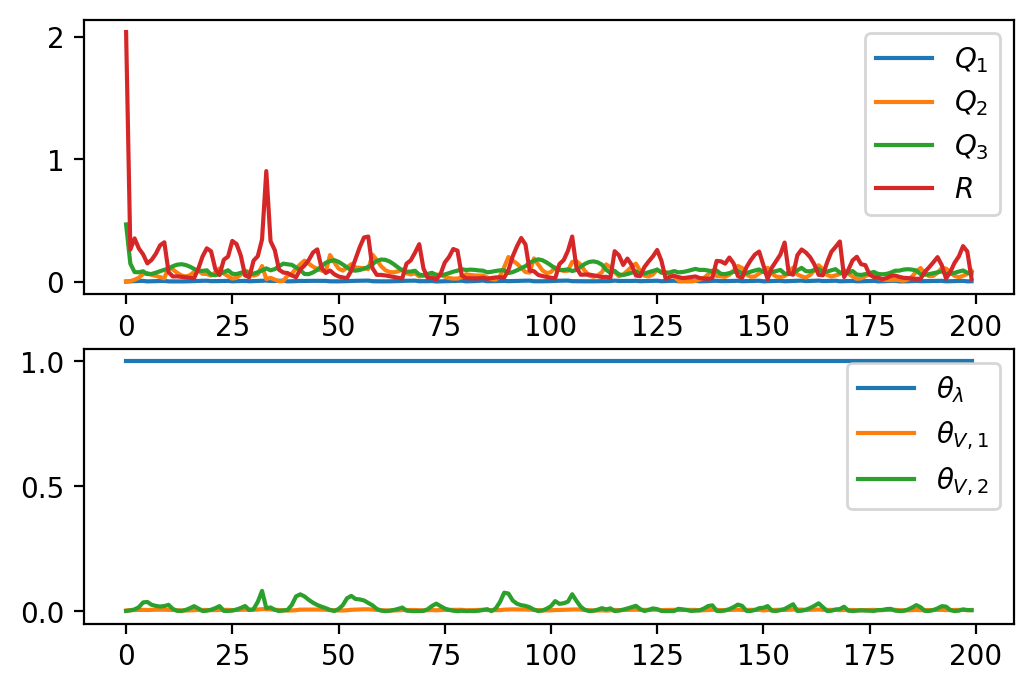

In [314]:
fig, (ax1, ax2) = plt.subplots(2,1, dpi=200)

ax1.plot(np.array(grad_weights_vect).reshape(-1,4)[:,0], label='$Q_1$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,4)[:,1], label='$Q_2$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,4)[:,2], label='$Q_3$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,4)[:,3], label='$R$')
ax1.legend()

ax2.plot(np.array(grad_theta_vect).reshape(-1,3)[:,0], label=r'$\theta_{\lambda}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,3)[:,1], label=r'$\theta_{V,1}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,3)[:,2], label=r'$\theta_{V,2}$')
ax2.legend()

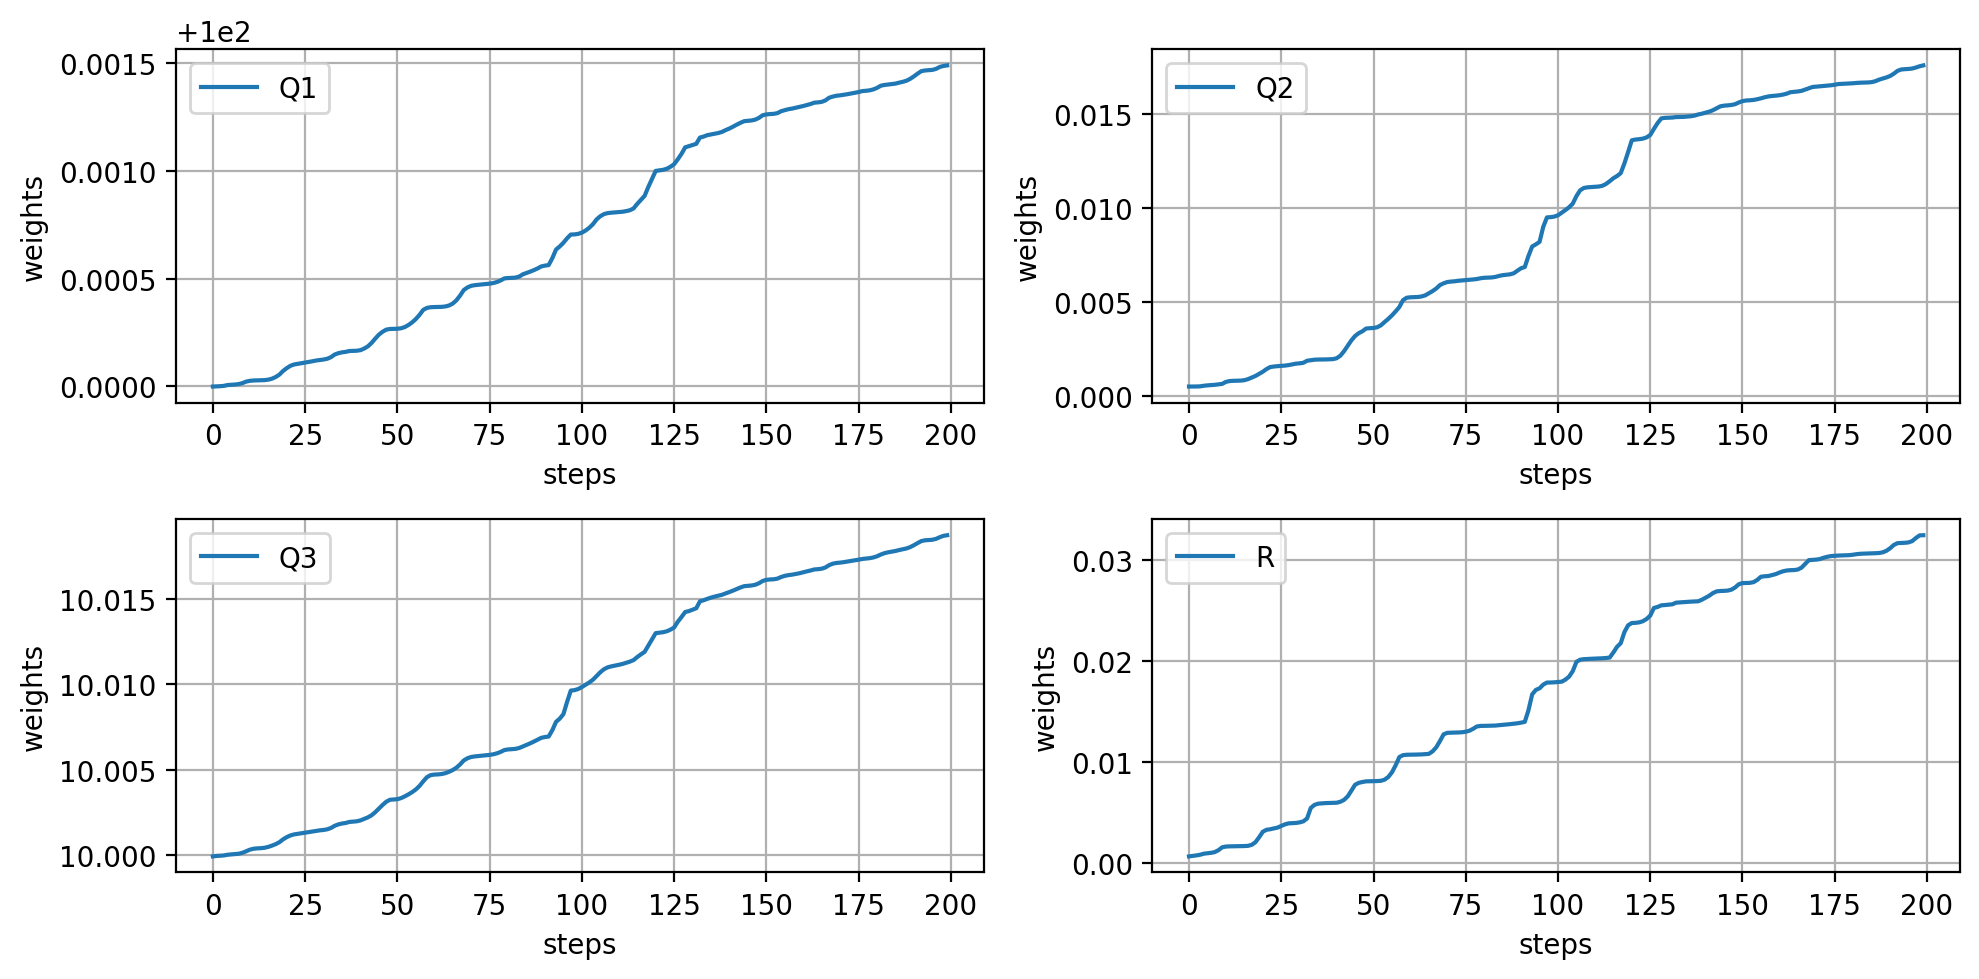

In [315]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,constrained_layout=False, figsize=(10, 5), dpi=200)
ax1.plot(np.array(weights_vect).reshape(-1,4)[:,0], label='Q1')
ax1.legend()
ax1.set_xlabel('steps')
ax1.set_ylabel('weights')
ax1.grid(True)

ax2.plot(np.array(weights_vect).reshape(-1,4)[:,1], label='Q2')
ax2.legend()
ax2.set_xlabel('steps')
ax2.set_ylabel('weights')
ax2.grid(True)

ax3.plot(np.array(weights_vect).reshape(-1,4)[:,2], label='Q3')
ax3.legend()
ax3.grid(True)
ax3.set_xlabel('steps')
ax3.set_ylabel('weights')

ax4.plot(np.array(weights_vect).reshape(-1,4)[:,3], label='R')
ax4.legend()
ax4.grid(True)
ax4.set_xlabel('steps')
ax4.set_ylabel('weights')
plt.tight_layout()

In [316]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [317]:
print('weights_vect: ', weights_vect[-1])
print('theta_vect: ', theta_vect[-1])

weights_vect:  [100.001, 0.0176172, 10.0187, 0.0324061]
theta_vect:  [0.203379, 0.000975134, 0.00302669]


Con offset costante su x = 0.005, a partire da beta = 0.0 converge a 0.010 (10000 steps)
Con offset costante su x = 0.01, a partire da beta = 0.0 converge a ?? (10000 steps)
Con offset costante su x = 0.005, a partire da beta = 0.01 converge a ?? (10000 steps)

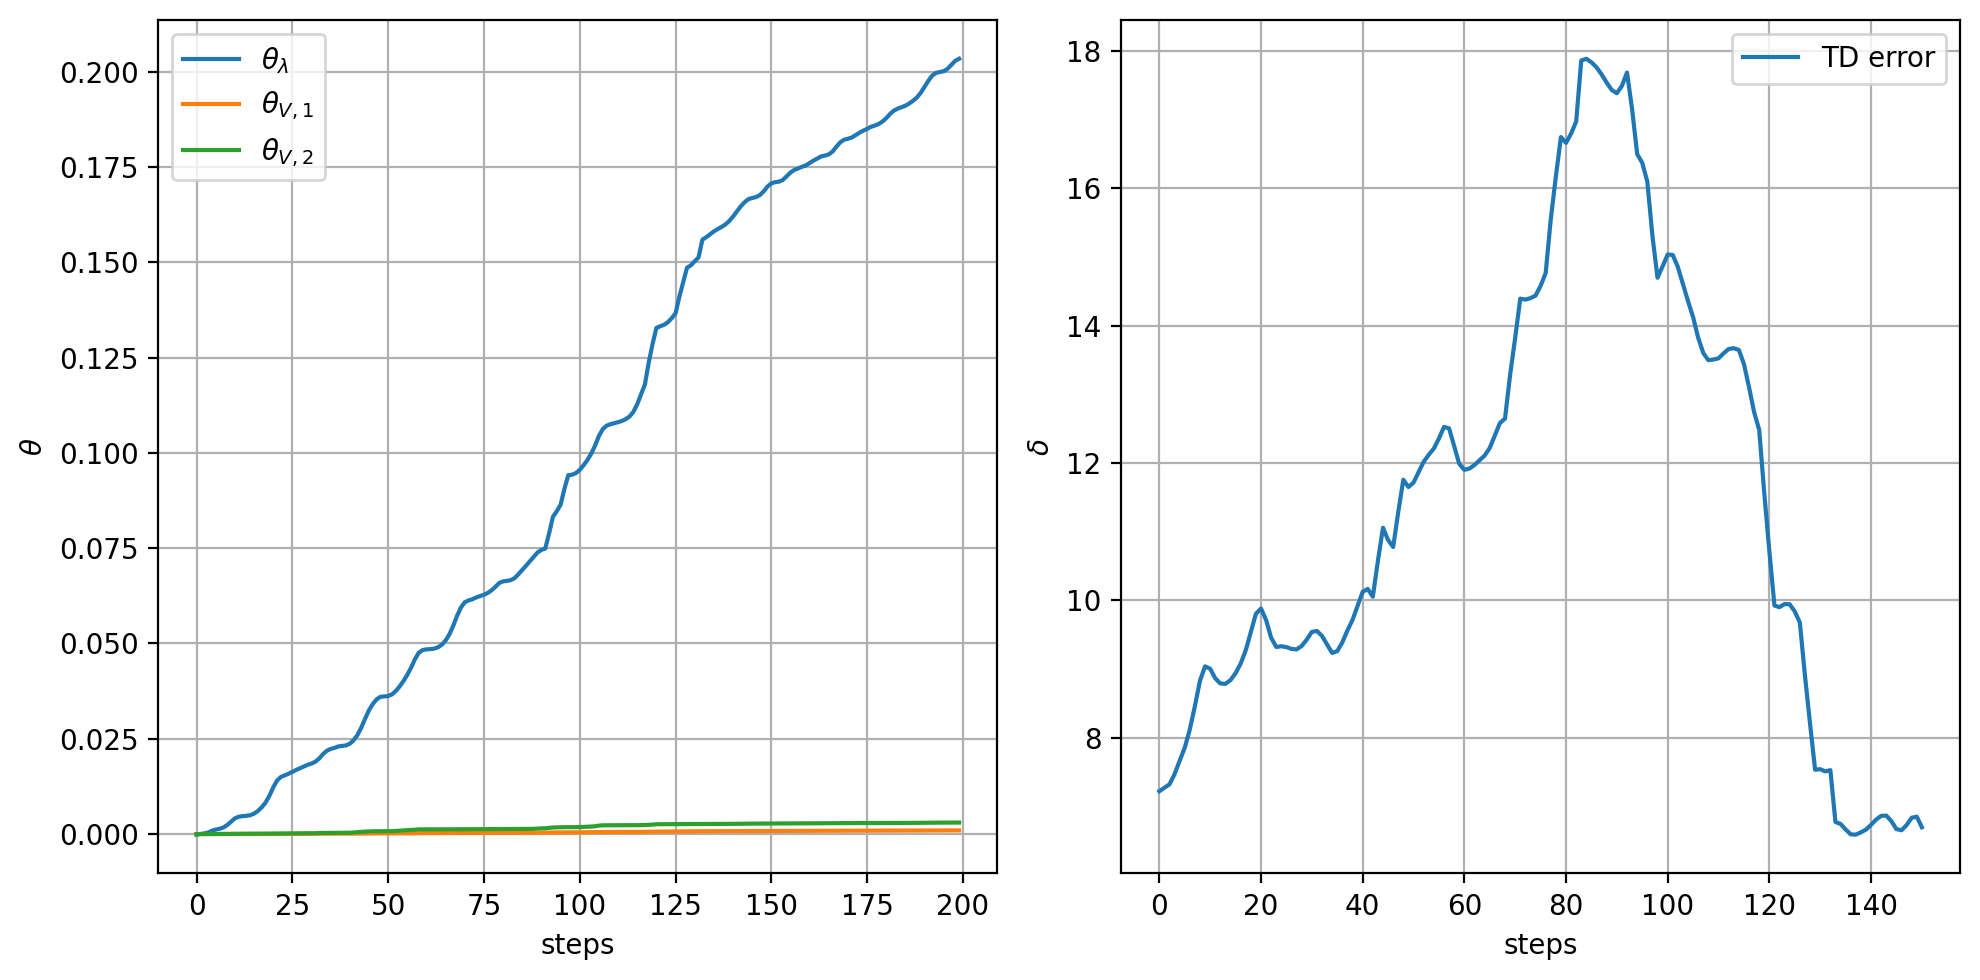

In [318]:
fig, (ax1, ax2) = plt.subplots(1,2,constrained_layout=False, figsize=(10, 5), dpi=200)
ax1.plot(np.array(theta_vect).reshape(-1,3)[:,0], label=r'$\theta_\lambda$')
ax1.plot(np.array(theta_vect).reshape(-1,3)[:,1], label=r'$\theta_{V,1}$')
ax1.plot(np.array(theta_vect).reshape(-1,3)[:,2], label=r'$\theta_{V,2}$')
ax1.legend()
ax1.set_xlabel('steps')
ax1.set_ylabel(r'$\theta$')
ax1.grid(True)

ax2.plot(moving_average(np.array(delta_vect).flatten(), 50), label='TD error')
ax2.legend()
#ax2.plot(np.array(delta_vect).flatten())
ax2.grid(True)
ax2.set_xlabel('steps')
ax2.set_ylabel(r'$\delta$')
plt.tight_layout()

In [319]:
theta_vect[-1]

DM([0.203379, 0.000975134, 0.00302669])

In [320]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5216462764857138, max speed is 0.6'

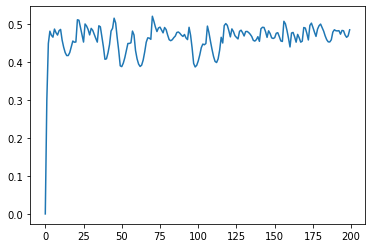

In [321]:
plt.plot(X_log[3,:])

In [322]:
errors = np.array(errors).reshape(-1)
f"Mean error: {errors.mean()}"

'Mean error: 0.05125282100435308'

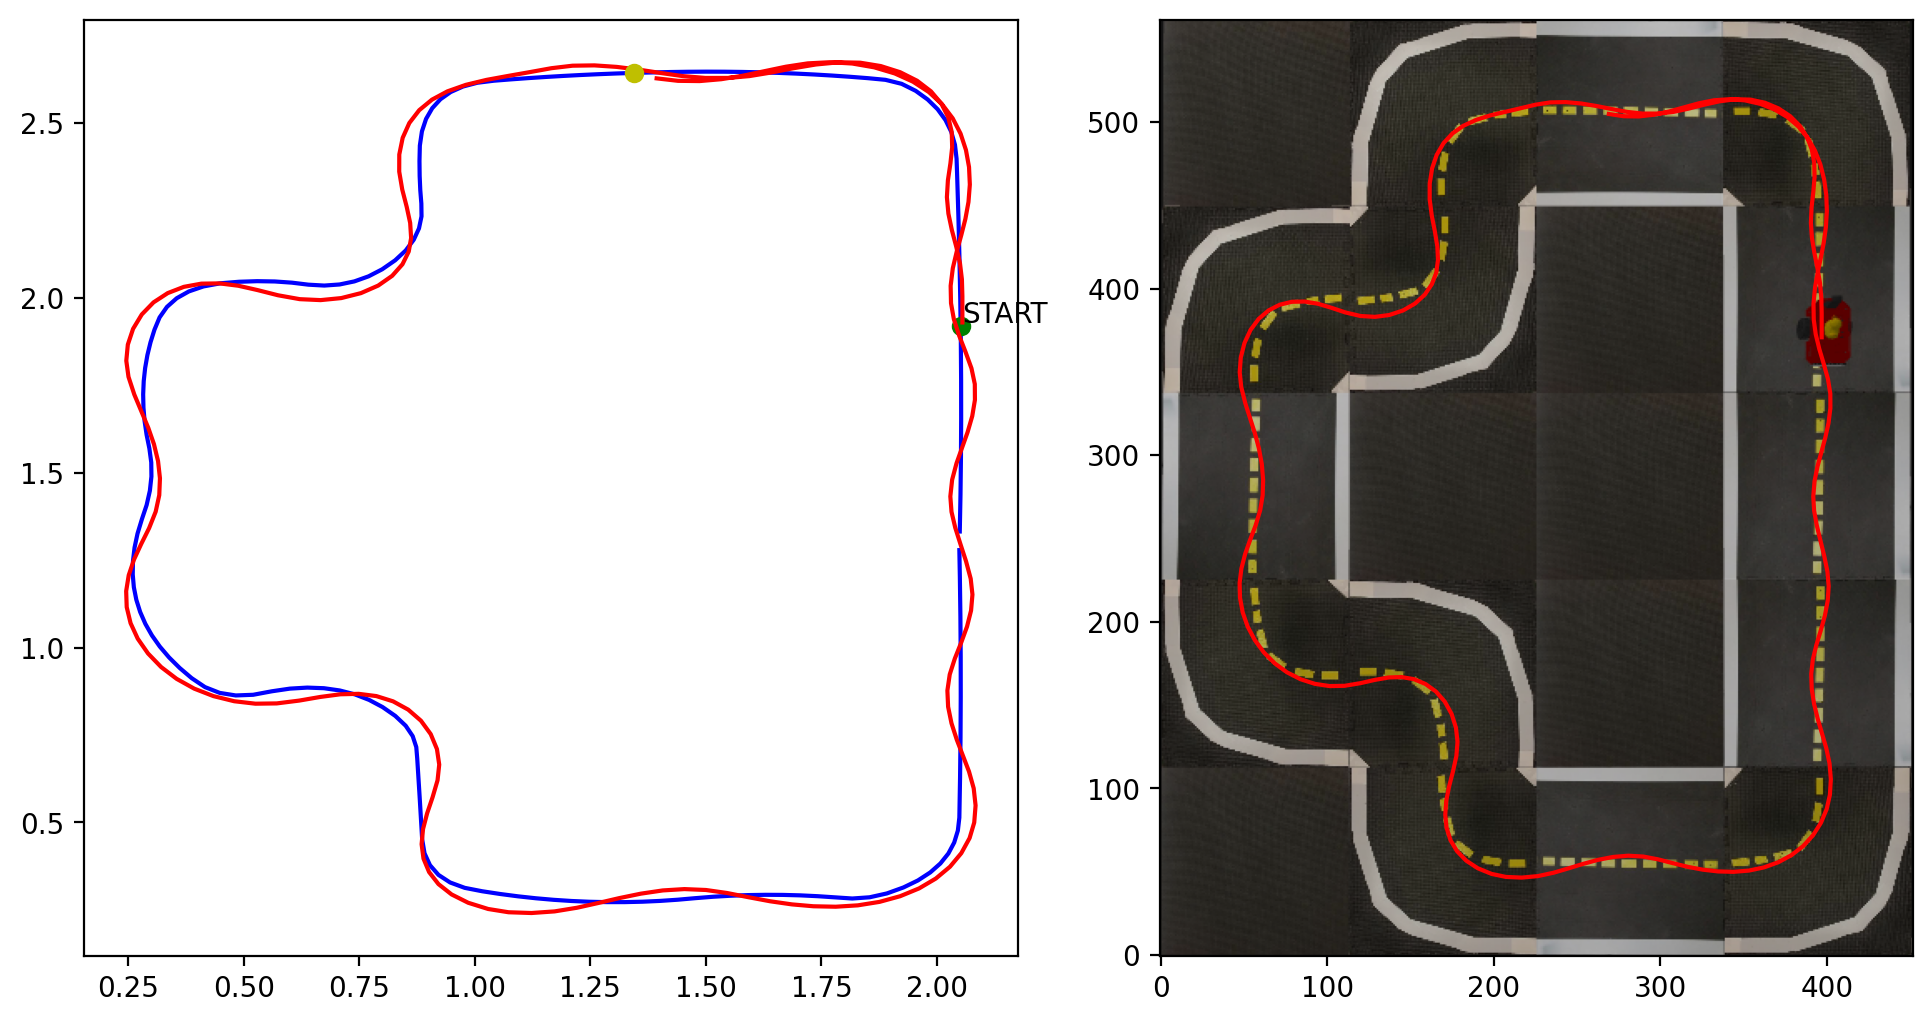

In [323]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5), dpi=200)
traj = np.array(traj)
index = int(index)
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

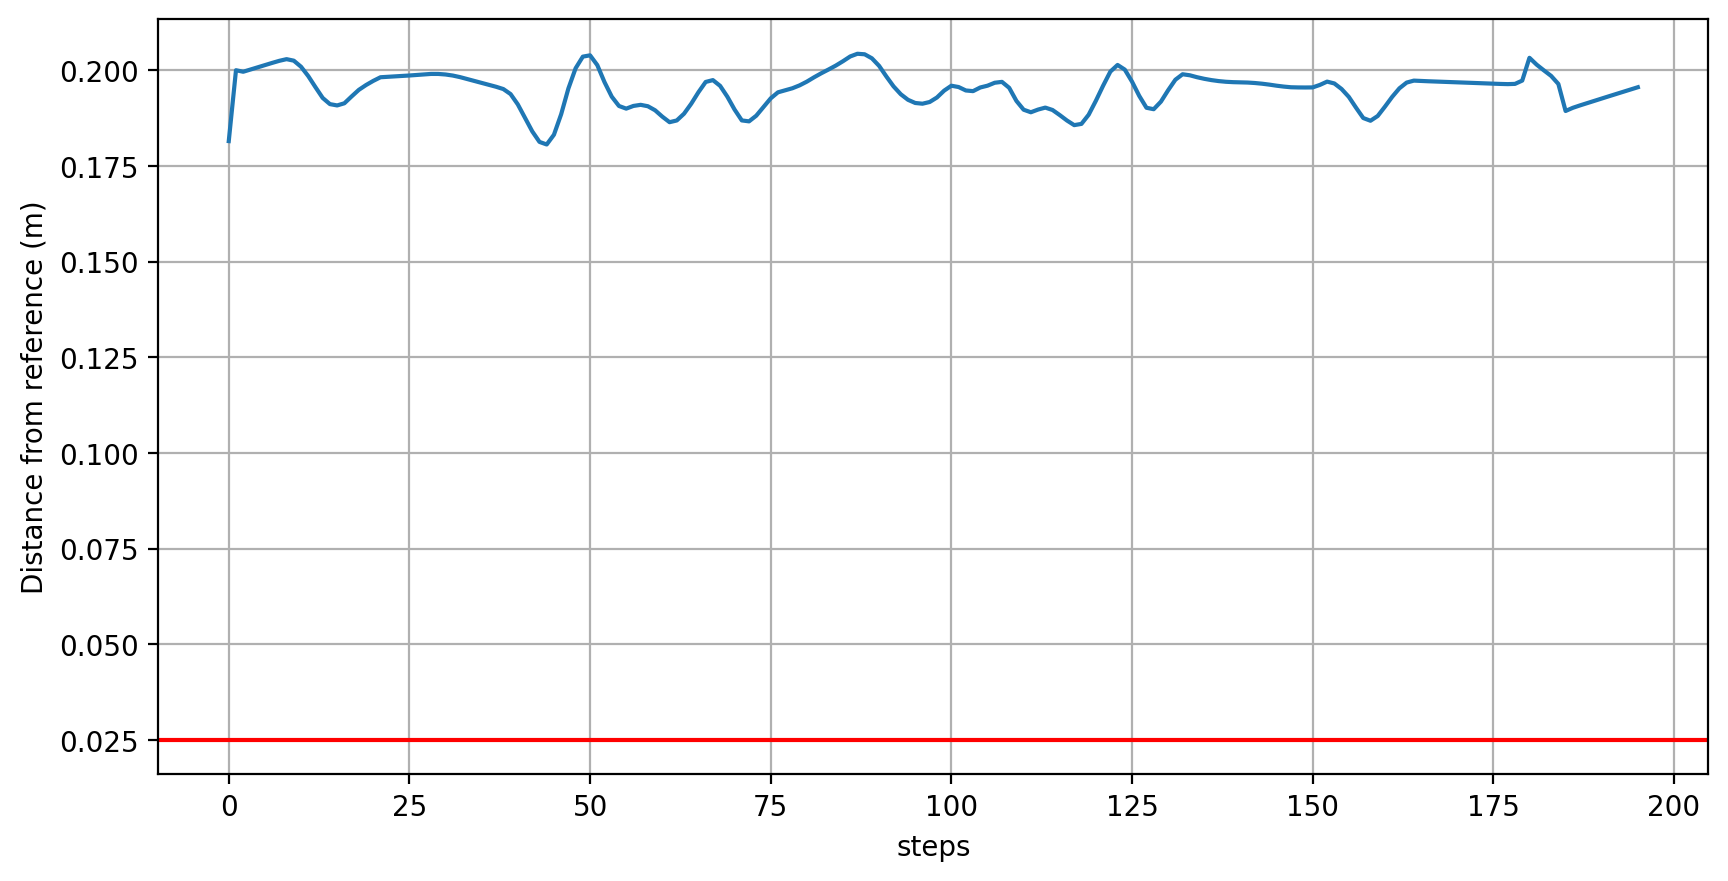

In [289]:
plt.figure(figsize=(10,5), dpi=200)
#plt.xticks(np.arange(0, len(errors)*dt+1, 1.0))
plt.plot(moving_average(np.sqrt(errors), 5))
plt.axhline(y=0.025, color='r', linestyle='-')
plt.xlabel("steps")
plt.ylabel("Distance from reference (m)")
plt.grid(True)

Text(0.5, 0, 'Time (s)')

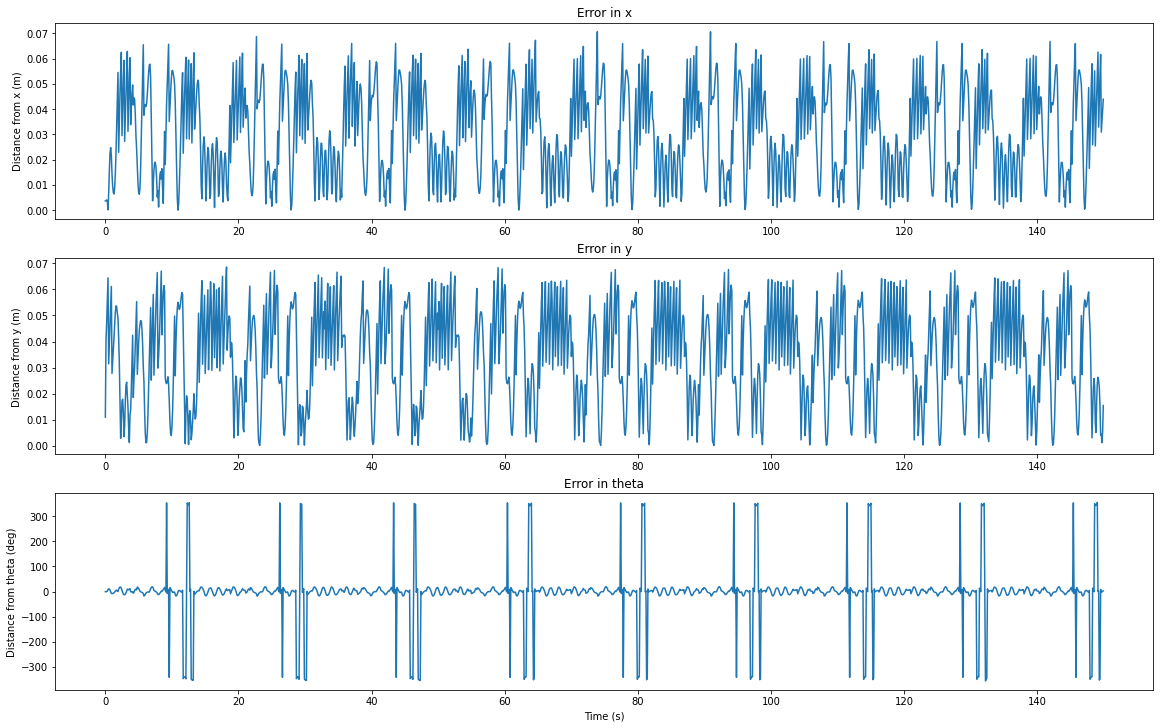

In [221]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, (error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

## Parameters sensitivity

In [601]:
td_graph = False

### Multi parameter sensitivity

In [752]:
if td_graph:
    errors_Q = []

    for Q_ in np.logspace(-4, 2, 20):
        errors_Q2 = []
        for Q2_ in np.logspace(-4, 2, 20):
            X_log = np.empty((5,0))
            U_log = np.empty((2,0))

            x = [pose.x, pose.y, pose.theta, 0, 0]
            r = r0
            tr = t0
            idx = index
            u_delay = u_delay0
            errors = []
            error_x = []
            error_y = []
            error_theta = []

            kdtree = spatial.KDTree(traj[:, :2])
            for i in range(50):
                u = M(x, r, tr, u_delay, Q_, Q2_, 1, 1)

                U_log = np.column_stack((U_log, u))
                X_log = np.column_stack((X_log, x))

                u_delay = np.column_stack((u_delay, u))[:, -delay:]

                # simulate
                x = F(x,u)

                distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
                errors.append(distance)
                error_x.append(traj[idx, 0] - x[0])
                error_y.append(traj[idx, 1] - x[1])
                error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

                _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
                r = traj[idx:idx+N+1, :2].T
                tr = traj[idx:idx+N+1, 2].T
            errors_Q2.append(np.array(errors).reshape(-1).sum())
        errors_Q.append(errors_Q2)

In [37]:
if td_graph:
    import matplotlib.ticker as mticker
    import matplotlib as mpl

    mpl.style.use("default")
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(np.log10(np.logspace(-4, 2, 20)), np.log10(np.logspace(-4, 2, 20)), np.array(errors_Q), label="J")

    # My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
    def log_tick_formatter(val, pos=None):
        return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
        #return f"{10**val:.2e}"      # e-Notation

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.set_xlabel('Q1', fontsize=15, rotation=0, labelpad=10)
    ax.set_ylabel('Q2', fontsize=15, labelpad=15)
    ax.set_zlabel('J', fontsize=15, rotation=0, labelpad=10)
    ax.yaxis.set_rotate_label(False)

    ax.grid(True)

    ax.set_title('Q1 vs Q2')

#### Sensitivity to Q1/Q2
FIxed Q3 and R

In [38]:
errors_Q = []

for Q_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []
    error_x = []
    error_y = []
    error_theta = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q_, 1, 1e-2, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)
        error_x.append(traj[idx, 0] - x[0])
        error_y.append(traj[idx, 1] - x[1])
        error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q.append(np.array(errors).reshape(-1).sum())

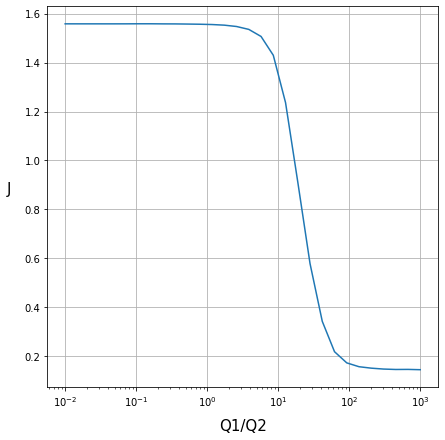

In [61]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q)
ax.set_xlabel('Q1/Q2', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q1 vs Q3

In [57]:
errors_Q2 = []

for Q2_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q2_, 1e-2, 1, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q2.append(np.array(errors).reshape(-1).sum())

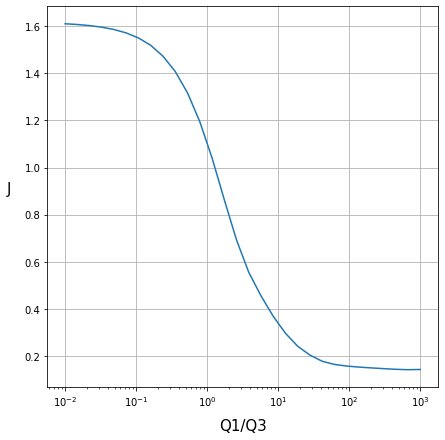

In [63]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q2)
ax.set_xlabel('Q1/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q2/Q3

In [91]:
errors_Q3 = []

for Q3_ in np.logspace(-5, 5, 40):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, 1e2, Q3_, 1, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q3.append(np.array(errors).reshape(-1).sum())

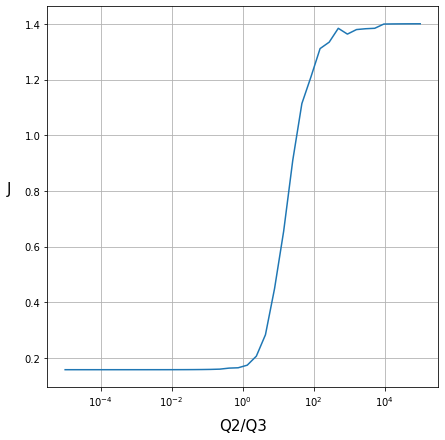

In [92]:
fig, ax = plt.subplots()
x = np.logspace(-5, 5, 40)
ax.plot(x, errors_Q3)

ax.set_xlabel('Q2/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to R

In [45]:
sens_R = False

if sens_R:
    errors_R = []

    for R_ in np.logspace(-4, 2, 20):
        X_log = np.empty((5,0))
        U_log = np.empty((2,0))

        x = [pose.x, pose.y, pose.theta, 0, 0]
        r = r0
        tr = t0
        idx = index
        u_delay = u_delay0
        errors = []

        kdtree = spatial.KDTree(traj[:, :2])
        for i in range(50):
            u = M(x, r, tr, u_delay, 100, 5e-4, 1, R_)

            U_log = np.column_stack((U_log, u))
            X_log = np.column_stack((X_log, x))

            u_delay = np.column_stack((u_delay, u))[:, -delay:]

            # simulate
            x = F(x,u)

            distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
            errors.append(distance)

            _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
            r = traj[idx:idx+N+1, :2].T
            tr = traj[idx:idx+N+1, 2].T
        errors_R.append(np.array(errors).reshape(-1).sum())

In [ ]:
if sens_R:
    fig, ax = plt.subplots()
    x = np.logspace(-4, 2, 20)
    ax.plot(x, errors_R)

    # Set x scale to logarithmic
    ax.set_xscale('log')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [ ]:
M.save('M.casadi')

### Gym simulation

The MPC does not consider the delay yet!

In [ ]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

In [ ]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

In [ ]:
if record:
    utils.show_on_map(env, positions)

In [ ]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))